In [1]:
# !pip install plot_keras_history
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt
from plot_keras_history import show_history
import numpy as np
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import ModelCheckpoint
import h5py

In [2]:
# Load MNIST dataset
(X_train, Y_train), (X_test, Y_test) = keras.datasets.mnist.load_data()

# Define the number of classes
num_classes = 10

# Reshape the input data
x_train = X_train.reshape(60000, 784)
x_test = X_test.reshape(10000, 784)

# Convert data type to 'float32'
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

# Normalize input data
x_train /= 255
x_test /= 255

# Print input data shapes
print("Training input samples shape: ", x_train.shape)
print("Test input samples shape: ", x_test.shape)

Training input samples shape:  (60000, 784)
Test input samples shape:  (10000, 784)


In [3]:
# Convert labels to categorical format
y_train = keras.utils.to_categorical(Y_train, num_classes)
y_test = keras.utils.to_categorical(Y_test, num_classes)

# Print output data shapes
print("Training output samples shape: ", y_train.shape)
print("Test output samples shape: ", y_test.shape)

Training output samples shape:  (60000, 10)
Test output samples shape:  (10000, 10)


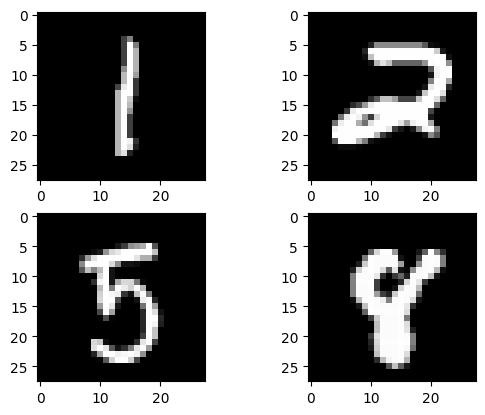

In [4]:
# Display a few training images
plt.subplot(221)
plt.imshow(X_train[310], cmap=plt.get_cmap('gray'))
plt.subplot(222)
plt.imshow(X_train[515], cmap=plt.get_cmap('gray'))
plt.subplot(223)
plt.imshow(X_train[1210], cmap=plt.get_cmap('gray'))
plt.subplot(224)
plt.imshow(X_train[2150], cmap=plt.get_cmap('gray'))
plt.show()

In [5]:
# let's try a basic neural network for digit classification
model = keras.Sequential()
model.add(layers.Dense(20, activation='sigmoid', input_shape=(784,)))
model.add(layers.Dense(20, activation='sigmoid'))
model.add(layers.Dense(num_classes, activation='softmax'))
model.summary()

/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/core/dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 20)             │        15,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 20)             │           420 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │           210 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,330 (63.79 KB)

 Trainable params: 16,330 (63.79 KB)

 Non-trainable params: 0 (0.00 B)

In [6]:
# Set up the learning rate and optimizer
learning_rate = 1e-3
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

# Compile the model with the loss function, metrics, and optimizer
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=optimizer)

In [7]:
import mlflow
import os

# Set up MLflow tracking
mlflow_tracking_uri = "http://127.0.0.1:5100"
mlflow.login()
mlflow.set_tracking_uri(mlflow_tracking_uri)

2024/04/18 09:54:41 INFO mlflow.utils.credentials: Successfully connected to MLflow hosted tracking server! Host: https://community.cloud.databricks.com.


In [8]:
# Set up MLflow experiment and tracking
mlflow_experiment_name = "mlflow-tf-keras-mnist-3"
mlflow.set_experiment(mlflow_experiment_name)
track = "custom_logger"

# Set up MLflow autologging or custom logger
if track == "autolog":
    mlflow.tensorflow.autolog()
    mlflow.autolog()
    history = model.fit(x_train, y_train, epochs=10, validation_data=(x_test, y_test))
else:
    with mlflow.start_run():
        # Train the model and log the metrics, parameters, and model
        history = model.fit(x_train, y_train, epochs=10, validation_data=(x_test, y_test))
        avg_val_loss = sum(history.history["val_loss"])/len(history.history["val_loss"])
        avg_val_accuracy = sum(history.history["val_accuracy"])/len(history.history["val_accuracy"])
        mlflow.log_metrics({"log_metrics_loss": avg_val_loss, "log_metrics_accuracy": avg_val_accuracy})
        mlflow.log_param("learning_rate", learning_rate)
        mlflow.log_param("optimizer", optimizer)
        mlflow.log_param("config", "basic")

2024/04/18 09:54:41 INFO mlflow.tracking.fluent: Experiment with name 'mlflow-tf-keras-mnist-3' does not exist. Creating a new experiment.


Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 592us/step - accuracy: 0.5832 - loss: 1.5414 - val_accuracy: 0.8943 - val_loss: 0.4484
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 534us/step - accuracy: 0.9028 - loss: 0.3906 - val_accuracy: 0.9234 - val_loss: 0.2762
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 524us/step - accuracy: 0.9284 - loss: 0.2576 - val_accuracy: 0.9357 - val_loss: 0.2245
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 487us/step - accuracy: 0.9393 - loss: 0.2127 - val_accuracy: 0.9427 - val_loss: 0.2003
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 493us/step - accuracy: 0.9449 - loss: 0.1899 - val_accuracy: 0.9468 - val_loss: 0.1819
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 486us/step - accuracy: 0.9500 - loss: 0.1694 - val_accuracy: 0.9499 - val_loss: 0.1744
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 484us/step - accuracy: 0.9540 - loss: 0.1567 - val_accuracy: 0.9509 - val_loss: 0.1639
Epoch 8/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 510us/step - accuracy: 0.9573 -

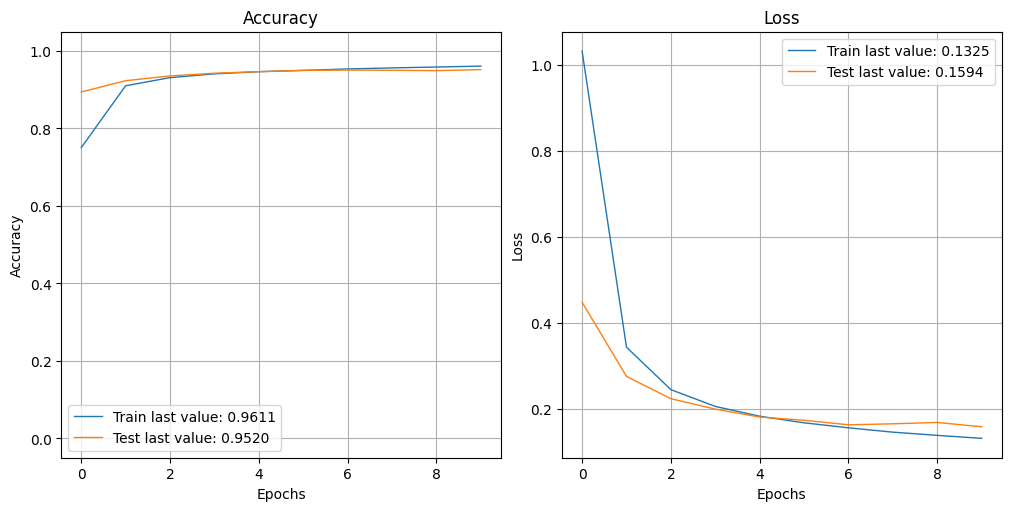

In [9]:
show_history(history)

In [10]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=2)
print("Test accuracy: {:.2f}%".format(100 * test_accuracy))

# Evaluate the model on the training set
train_loss, train_accuracy = model.evaluate(x_train, y_train, verbose=2)
print("Train accuracy: {:.2f}%".format(100 * train_accuracy))

313/313 - 0s - 343us/step - accuracy: 0.9520 - loss: 0.1594
Test accuracy: 95.20%
1875/1875 - 1s - 304us/step - accuracy: 0.9638 - loss: 0.1241
Train accuracy: 96.38%


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Predicted Digit: 3


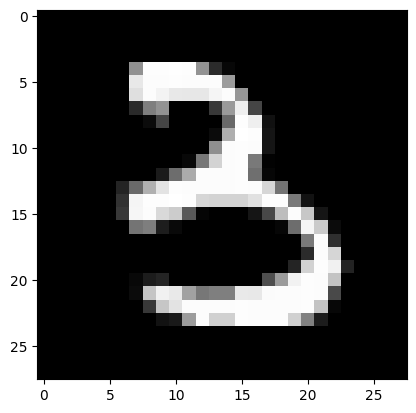

In [11]:
# check if the prediction is working fine for a random test point
test_pt = 782
plt.imshow(X_test[test_pt], cmap=plt.get_cmap('gray'))
probs = model.predict(x_test[test_pt:test_pt+1], verbose=True)
print("Predicted Digit:", np.argmax(probs))

# Rest of the Configuration

In [12]:
# Let's try with a slightly bigger model with more parameters.
model2 = keras.Sequential()
model2.add(layers.Dense(256, activation='sigmoid', input_shape=(784,)))
model2.add(layers.Dense(128, activation='sigmoid'))
model2.add(layers.Dense(num_classes, activation='softmax'))
model2.summary()

/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/core/dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 256)            │       200,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 235,146 (918.54 KB)

 Trainable params: 235,146 (918.54 KB)

 Non-trainable params: 0 (0.00 B)

In [13]:
# Set up the learning rate and optimizer
learning_rate = 1e-3
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

# Compile the larger neural network with the loss function, metrics, and optimizer
model2.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=optimizer)

# Set up MLflow experiment and tracking
mlflow_experiment_name = "mlflow-tf-keras-mnist-3"
mlflow.set_experiment(mlflow_experiment_name)
track = "custom_logger"

# Set up MLflow autologging or custom logger
if track == "autolog":
    mlflow.tensorflow.autolog()
    mlflow.autolog()
    history = model2.fit(x_train, y_train, epochs=10, validation_data=(x_test, y_test))
else:
    with mlflow.start_run():
        # Train the larger neural network and log the metrics, parameters, and model
        history = model2.fit(x_train, y_train, epochs=10, validation_data=(x_test, y_test))
        avg_val_loss = sum(history.history["val_loss"])/len(history.history["val_loss"])
        avg_val_accuracy = sum(history.history["val_accuracy"])/len(history.history["val_accuracy"])
        mlflow.log_metrics({"log_metrics_loss": avg_val_loss, "log_metrics_accuracy": avg_val_accuracy})
        mlflow.log_param("learning_rate", learning_rate)
        mlflow.log_param("optimizer", optimizer)
        mlflow.log_param("config", "bigger")

Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8100 - loss: 0.6972 - val_accuracy: 0.9445 - val_loss: 0.1903
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9475 - loss: 0.1727 - val_accuracy: 0.9607 - val_loss: 0.1235
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9688 - loss: 0.1059 - val_accuracy: 0.9705 - val_loss: 0.0939
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9778 - loss: 0.0730 - val_accuracy: 0.9746 - val_loss: 0.0804
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9844 - loss: 0.0509 - val_accuracy: 0.9780 - val_loss: 0.0725
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9878 - loss: 0.0388 - val_accuracy: 0.9785 - val_loss: 0.0681
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9909 - loss: 0.0289 - val_accuracy: 0.9769 - val_loss: 0.0756
Epoch 8/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9935 - loss: 0.0225 - 

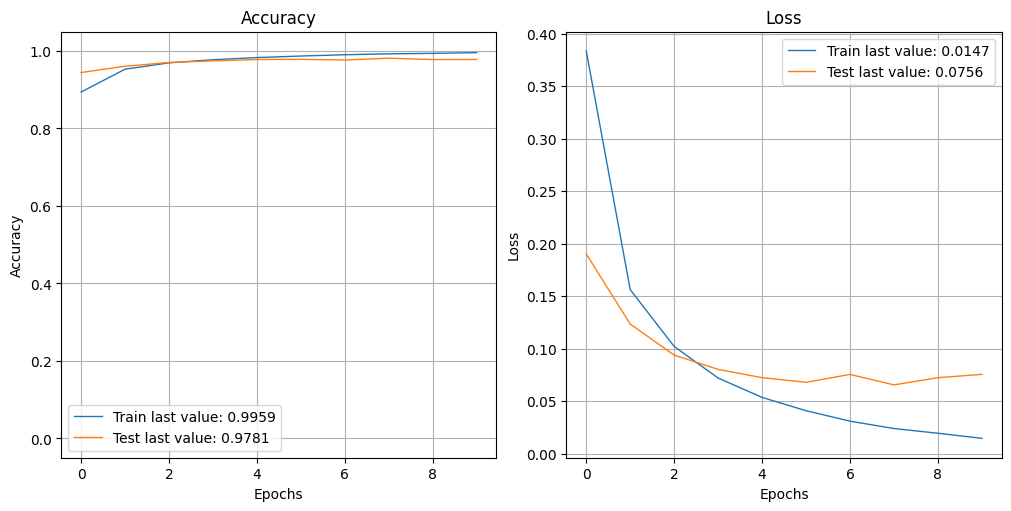

In [14]:
show_history(history)

In [15]:
# Evaluate the model on the test set
test_loss, test_accuracy = model2.evaluate(x_test, y_test, verbose=2)
print("Test accuracy: {:.2f}%".format(100 * test_accuracy))

# Evaluate the model on the training set
train_loss, train_accuracy = model2.evaluate(x_train, y_train, verbose=2)
print("Train accuracy: {:.2f}%".format(100 * train_accuracy))

313/313 - 0s - 511us/step - accuracy: 0.9781 - loss: 0.0756
Test accuracy: 97.81%
1875/1875 - 1s - 453us/step - accuracy: 0.9959 - loss: 0.0128
Train accuracy: 99.59%


In [16]:
# let's try adding kernel regularization to the mix.
model_r = keras.Sequential()
model_r.add(layers.Dense(256, activation='sigmoid', input_shape=(784,), kernel_regularizer=regularizers.L2(0.01)))
model_r.add(layers.Dense(128, activation='sigmoid', kernel_regularizer=regularizers.L2(0.01)))
model_r.add(layers.Dense(num_classes, activation='softmax'))
model_r.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                 │ (None, 256)            │       200,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 235,146 (918.54 KB)

 Trainable params: 235,146 (918.54 KB)

 Non-trainable params: 0 (0.00 B)

In [17]:
# Set up the learning rate and optimizer
learning_rate = 1e-3
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

# Compile the regularized neural network with the loss function, metrics, and optimizer
model_r.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=optimizer)

# Set up MLflow experiment and tracking
mlflow_experiment_name = "mlflow-tf-keras-mnist-3"
mlflow.set_experiment(mlflow_experiment_name)
track = "custom_logger"

# Set up MLflow autologging or custom logger
if track == "autolog":
    mlflow.tensorflow.autolog()
    mlflow.autolog()
    history = model_r.fit(x_train, y_train, epochs=50, steps_per_epoch=50, validation_data=(x_test, y_test))
else:
    with mlflow.start_run():
        # Train the regularized neural network and log the metrics, parameters, and model
        history = model_r.fit(x_train, y_train, epochs=50, steps_per_epoch=50, validation_data=(x_test, y_test))
        avg_val_loss = sum(history.history["val_loss"])/len(history.history["val_loss"])
        avg_val_accuracy = sum(history.history["val_accuracy"])/len(history.history["val_accuracy"])
        mlflow.log_metrics({"log_metrics_loss": avg_val_loss, "log_metrics_accuracy": avg_val_accuracy})
        mlflow.log_param("learning_rate", learning_rate)
        mlflow.log_param("optimizer", optimizer)
        mlflow.log_param("config", "regularisation")

Epoch 1/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.2293 - loss: 6.1462 - val_accuracy: 0.5606 - val_loss: 3.0276
Epoch 2/50


2024-04-18 09:55:30.749885: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/opt/homebrew/Cellar/python@3.11/3.11.9/Frameworks/Python.framework/Versions/3.11/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.5606 - val_loss: 3.0276
Epoch 3/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5242 - loss: 2.7022 - val_accuracy: 0.5733 - val_loss: 2.0790
Epoch 4/50


2024-04-18 09:55:31.489638: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.5733 - val_loss: 2.0790
Epoch 5/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5960 - loss: 2.0021 - val_accuracy: 0.6436 - val_loss: 1.8046
Epoch 6/50


2024-04-18 09:55:32.253752: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.6436 - val_loss: 1.8046
Epoch 7/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.6566 - loss: 1.7791 - val_accuracy: 0.6617 - val_loss: 1.6760
Epoch 8/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.6617 - val_loss: 1.6760
Epoch 9/50


2024-04-18 09:55:33.004715: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.6866 - loss: 1.6677 - val_accuracy: 0.7148 - val_loss: 1.5919
Epoch 10/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.7148 - val_loss: 1.5919
Epoch 11/50


2024-04-18 09:55:33.704356: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7093 - loss: 1.5858 - val_accuracy: 0.7433 - val_loss: 1.5273
Epoch 12/50


2024-04-18 09:55:34.415447: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.7433 - val_loss: 1.5273
Epoch 13/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7327 - loss: 1.5305 - val_accuracy: 0.7464 - val_loss: 1.4733
Epoch 14/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.7464 - val_loss: 1.4733
Epoch 15/50


2024-04-18 09:55:35.134270: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7492 - loss: 1.4821 - val_accuracy: 0.7570 - val_loss: 1.4310
Epoch 16/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.7570 - val_loss: 1.4310
Epoch 17/50


2024-04-18 09:55:35.860032: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7647 - loss: 1.4383 - val_accuracy: 0.7733 - val_loss: 1.3949
Epoch 18/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.7733 - val_loss: 1.3949
Epoch 19/50


2024-04-18 09:55:36.562123: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7685 - loss: 1.4051 - val_accuracy: 0.7965 - val_loss: 1.3603
Epoch 20/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.7965 - val_loss: 1.3603
Epoch 21/50


2024-04-18 09:55:37.264746: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7804 - loss: 1.3716 - val_accuracy: 0.7893 - val_loss: 1.3275
Epoch 22/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.7893 - val_loss: 1.3275
Epoch 23/50


2024-04-18 09:55:37.964834: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7832 - loss: 1.3408 - val_accuracy: 0.8023 - val_loss: 1.3040
Epoch 24/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.8023 - val_loss: 1.3040
Epoch 25/50


2024-04-18 09:55:38.677139: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7895 - loss: 1.3196 - val_accuracy: 0.7921 - val_loss: 1.2844
Epoch 26/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.7921 - val_loss: 1.2844
Epoch 27/50


2024-04-18 09:55:39.405394: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7909 - loss: 1.2966 - val_accuracy: 0.8012 - val_loss: 1.2593
Epoch 28/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.8012 - val_loss: 1.2593
Epoch 29/50


2024-04-18 09:55:40.122991: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7986 - loss: 1.2724 - val_accuracy: 0.8067 - val_loss: 1.2353
Epoch 30/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.8067 - val_loss: 1.2353
Epoch 31/50


2024-04-18 09:55:40.833962: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7993 - loss: 1.2541 - val_accuracy: 0.8005 - val_loss: 1.2232
Epoch 32/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.8005 - val_loss: 1.2232
Epoch 33/50


2024-04-18 09:55:41.549718: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8004 - loss: 1.2382 - val_accuracy: 0.8087 - val_loss: 1.2063
Epoch 34/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.8087 - val_loss: 1.2063
Epoch 35/50


2024-04-18 09:55:42.282032: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8013 - loss: 1.2238 - val_accuracy: 0.8027 - val_loss: 1.1998
Epoch 36/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.8027 - val_loss: 1.1998
Epoch 37/50


2024-04-18 09:55:42.997554: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8021 - loss: 1.2143 - val_accuracy: 0.8163 - val_loss: 1.1715
Epoch 38/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.8163 - val_loss: 1.1715
Epoch 39/50


2024-04-18 09:55:43.709462: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8069 - loss: 1.1953 - val_accuracy: 0.8176 - val_loss: 1.1614
Epoch 40/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.8176 - val_loss: 1.1614
Epoch 41/50


2024-04-18 09:55:44.419687: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8112 - loss: 1.1772 - val_accuracy: 0.8142 - val_loss: 1.1534
Epoch 42/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.8142 - val_loss: 1.1534
Epoch 43/50


2024-04-18 09:55:45.141248: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8094 - loss: 1.1689 - val_accuracy: 0.8139 - val_loss: 1.1361
Epoch 44/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.8139 - val_loss: 1.1361
Epoch 45/50


2024-04-18 09:55:45.857735: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8122 - loss: 1.1584 - val_accuracy: 0.8243 - val_loss: 1.1300
Epoch 46/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.8243 - val_loss: 1.1300
Epoch 47/50


2024-04-18 09:55:46.573659: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8122 - loss: 1.1514 - val_accuracy: 0.8201 - val_loss: 1.1205
Epoch 48/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.8201 - val_loss: 1.1205
Epoch 49/50


2024-04-18 09:55:47.286736: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8146 - loss: 1.1406 - val_accuracy: 0.8191 - val_loss: 1.1101
Epoch 50/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.8191 - val_loss: 1.1101


2024-04-18 09:55:48.028317: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


In [18]:
# Evaluate the regularized model on the test set
test_loss, test_accuracy = model_r.evaluate(x_test, y_test, verbose=2)
print("Test accuracy: {:.2f}%".format(100 * test_accuracy))

# Evaluate the regularized model on the training set
train_loss, train_accuracy = model_r.evaluate(x_train, y_train, verbose=2)
print("Train accuracy: {:.2f}%".format(100 * train_accuracy))

313/313 - 0s - 630us/step - accuracy: 0.8191 - loss: 1.1101
Test accuracy: 81.91%
1875/1875 - 1s - 555us/step - accuracy: 0.8141 - loss: 1.1320
Train accuracy: 81.41%


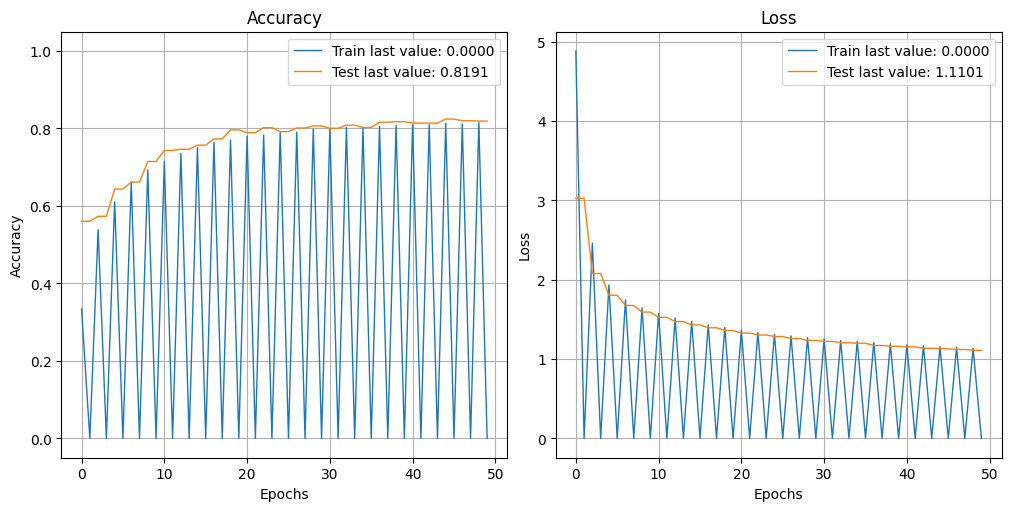

In [19]:
show_history(history)

In [20]:
model_rd = keras.Sequential()
model_rd.add(layers.Dense(256, activation='sigmoid', input_shape=(784,)))
model_rd.add(Dropout(0.7))
model_rd.add(layers.Dense(128, activation='sigmoid'))
model_rd.add(Dropout(0.6))
model_rd.add(layers.Dense(10, activation='softmax'))
model_rd.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_9 (Dense)                 │ (None, 256)            │       200,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 235,146 (918.54 KB)

 Trainable params: 235,146 (918.54 KB)

 Non-trainable params: 0 (0.00 B)

In [21]:
# Set up the learning rate and optimizer
learning_rate = 1e-3
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

# Compile the dropout neural network with the loss function, metrics, and optimizer
model_rd.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=optimizer)

# Set up MLflow experiment and tracking
mlflow_experiment_name = "mlflow-tf-keras-mnist-3"
mlflow.set_experiment(mlflow_experiment_name)
track = "custom_logger"

# Set up MLflow autologging or custom logger
if track == "autolog":
    mlflow.tensorflow.autolog()
    mlflow.autolog()
    history = model_rd.fit(x_train, y_train, epochs=10)
else:
    with mlflow.start_run():
        # Train the dropout neural network and log the metrics, parameters, and model
        history = model_rd.fit(x_train, y_train, epochs=10, validation_data=(x_test, y_test))
        avg_val_loss = sum(history.history["val_loss"])/len(history.history["val_loss"])
        avg_val_accuracy = sum(history.history["val_accuracy"])/len(history.history["val_accuracy"])
        mlflow.log_metrics({"log_metrics_loss": avg_val_loss, "log_metrics_accuracy": avg_val_accuracy})
        mlflow.log_param("learning_rate", learning_rate)
        mlflow.log_param("optimizer", optimizer)
        mlflow.log_param("config", "dropout")

Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.5472 - loss: 1.3357 - val_accuracy: 0.9160 - val_loss: 0.2846
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8714 - loss: 0.4343 - val_accuracy: 0.9345 - val_loss: 0.2138
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8980 - loss: 0.3502 - val_accuracy: 0.9458 - val_loss: 0.1756
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9127 - loss: 0.3022 - val_accuracy: 0.9525 - val_loss: 0.1558
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9242 - loss: 0.2660 - val_accuracy: 0.9549 - val_loss: 0.1451
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9259 - loss: 0.2541 - val_accuracy: 0.9594 - val_loss: 0.1314
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9323 - loss: 0.2336 - val_accuracy: 0.9627 - val_loss: 0.1205
Epoch 8/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9389 - loss: 0.2129 - 

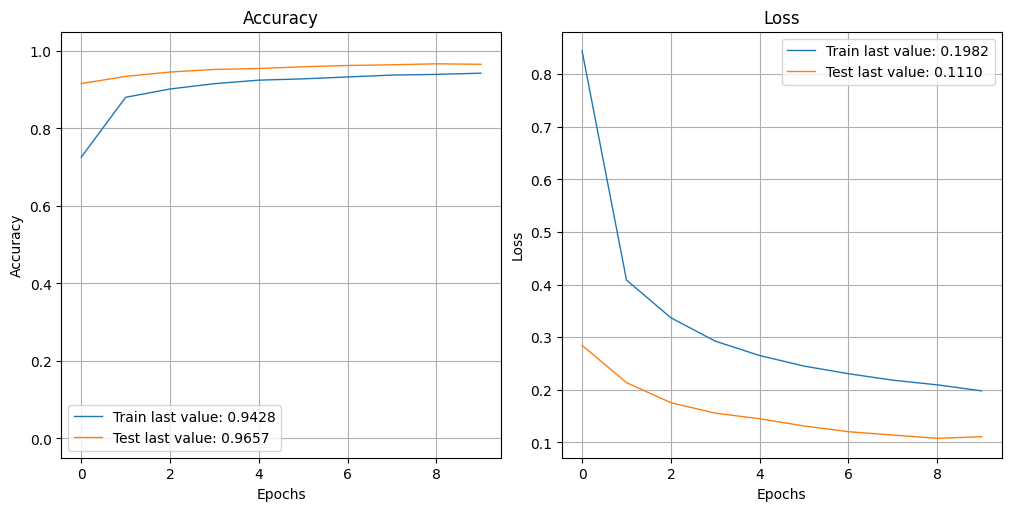

In [22]:
show_history(history)

In [23]:
# Evaluate the dropout model on the test set
test_loss, test_accuracy = model_rd.evaluate(x_test, y_test, verbose=2)
print("Test accuracy: {:.2f}%".format(100 * test_accuracy))

# Evaluate the dropout model on the training set
train_loss, train_accuracy = model_rd.evaluate(x_train, y_train, verbose=2)
print("Train accuracy: {:.2f}%".format(100 * train_accuracy))

313/313 - 0s - 509us/step - accuracy: 0.9657 - loss: 0.1110
Test accuracy: 96.57%
1875/1875 - 1s - 438us/step - accuracy: 0.9700 - loss: 0.0954
Train accuracy: 97.00%


In [24]:
# EARLY STOPPING METHOD
model_re = keras.Sequential()
model_re.add(layers.Dense(256, activation='sigmoid', input_shape=(784,)))
model_re.add(layers.Dense(128, activation='sigmoid'))
model_re.add(layers.Dense(num_classes, activation='softmax'))
model_re.summary()
model_re.compile(loss='categorical_crossentropy', metrics=['accuracy'])

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_12 (Dense)                │ (None, 256)            │       200,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 235,146 (918.54 KB)

 Trainable params: 235,146 (918.54 KB)

 Non-trainable params: 0 (0.00 B)

In [25]:
# Set up the EarlyStopping callback
es = keras.callbacks.EarlyStopping(monitor='val_accuracy', min_delta=0.01, patience=2)

# Set up MLflow experiment and tracking
mlflow_experiment_name = "mlflow-tf-keras-mnist-3"
mlflow.set_experiment(mlflow_experiment_name)
track = "custom_logger"

# Set up MLflow autologging or custom logger
if track == "autolog":
    mlflow.tensorflow.autolog()
    mlflow.autolog()
    history = model_re.fit(x_train, y_train, epochs=10, validation_data=(x_test, y_test), callbacks=[es])
else:
    with mlflow.start_run():
        # Train the early stopping model and log the metrics, parameters, and model
        history = model_re.fit(x_train, y_train, epochs=10, validation_data=(x_test, y_test), callbacks=[es])
        avg_val_loss = sum(history.history["val_loss"])/len(history.history["val_loss"])
        avg_val_accuracy = sum(history.history["val_accuracy"])/len(history.history["val_accuracy"])
        mlflow.log_metrics({"log_metrics_loss": avg_val_loss, "log_metrics_accuracy": avg_val_accuracy})
        mlflow.log_param("learning_rate", learning_rate)
        mlflow.log_param("optimizer", optimizer)
        mlflow.log_param("config", "early-stopping")

Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8054 - loss: 0.7036 - val_accuracy: 0.9311 - val_loss: 0.2193
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9407 - loss: 0.1940 - val_accuracy: 0.9572 - val_loss: 0.1418
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9604 - loss: 0.1295 - val_accuracy: 0.9601 - val_loss: 0.1275
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9723 - loss: 0.0929 - val_accuracy: 0.9713 - val_loss: 0.0932
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9764 - loss: 0.0774 - val_accuracy: 0.9735 - val_loss: 0.0831
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9824 - loss: 0.0603 - val_accuracy: 0.9776 - val_loss: 0.0746


In [26]:
# Using Learning rates now.
model3 = keras.Sequential()
model3.add(layers.Dense(20, activation='sigmoid', input_shape=(784,)))
model3.add(layers.Dense(10, activation='sigmoid'))
model3.add(layers.Dense(num_classes, activation='softmax'))
model3.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_15 (Dense)                │ (None, 20)             │        15,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 10)             │           210 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 10)             │           110 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,020 (62.58 KB)

 Trainable params: 16,020 (62.58 KB)

 Non-trainable params: 0 (0.00 B)

In [27]:
# Set up the high learning rate and optimizer
learning_rate = 10.
opt_new = keras.optimizers.SGD(learning_rate=learning_rate)

# Compile the SGD model with the loss function, metrics, and optimizer
model3.compile(optimizer=opt_new, loss='categorical_crossentropy', metrics=['accuracy'])

# Set up MLflow experiment and tracking
mlflow_experiment_name = "mlflow-tf-keras-mnist-3"
mlflow.set_experiment(mlflow_experiment_name)
track = "custom_logger"

# Set up MLflow autologging or custom logger
if track == "autolog":
    mlflow.tensorflow.autolog()
    mlflow.autolog()
    history = model3.fit(x_train, y_train, epochs=20, validation_data=(x_test, y_test))
else:
    with mlflow.start_run():
        # Train the SGD model with high learning rate and log the metrics, parameters, and model
        history = model3.fit(x_train, y_train, epochs=20, validation_data=(x_test, y_test))
        avg_val_loss = sum(history.history["val_loss"])/len(history.history["val_loss"])
        avg_val_accuracy = sum(history.history["val_accuracy"])/len(history.history["val_accuracy"])
        mlflow.log_metrics({"log_metrics_loss": avg_val_loss, "log_metrics_accuracy": avg_val_accuracy})
        mlflow.log_param("learning_rate", learning_rate)
        mlflow.log_param("optimizer", opt_new)
        mlflow.log_param("config", "SGD with High lr = 10")

Epoch 1/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 420us/step - accuracy: 0.1725 - loss: 2.3119 - val_accuracy: 0.3523 - val_loss: 1.7433
Epoch 2/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 358us/step - accuracy: 0.4218 - loss: 1.7034 - val_accuracy: 0.4643 - val_loss: 1.4581
Epoch 3/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 356us/step - accuracy: 0.5285 - loss: 1.4712 - val_accuracy: 0.6835 - val_loss: 1.1231
Epoch 4/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 353us/step - accuracy: 0.6026 - loss: 1.2323 - val_accuracy: 0.5739 - val_loss: 1.5017
Epoch 5/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 365us/step - accuracy: 0.6102 - loss: 1.2126 - val_accuracy: 0.6018 - val_loss: 1.0384
Epoch 6/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 354us/step - accuracy: 0.6306 - loss: 1.1352 - val_accuracy: 0.6278 - val_loss: 1.1359
Epoch 7/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 355us/step - accuracy: 0.6595 - loss: 1.0614 - val_accuracy: 0.6991 - val_loss: 1.0939
Epoch 8/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 356us/step - accuracy: 0.7128 -

In [28]:
# Set up the low learning rate and optimizer
learning_rate = 0.00001
opt_new = keras.optimizers.SGD(learning_rate=learning_rate)

# Define the SGD model with a low learning rate
model3 = keras.Sequential()
model3.add(layers.Dense(20, activation='sigmoid', input_shape=(784,)))
model3.add(layers.Dense(10, activation='sigmoid'))
model3.add(layers.Dense(10, activation='softmax'))
model3.summary()

# Compile the SGD model with the loss function, metrics, and optimizer
model3.compile(optimizer=opt_new, loss='categorical_crossentropy', metrics=['accuracy'])

# Set up MLflow experiment and tracking
mlflow_experiment_name = "mlflow-tf-keras-mnist-3"
mlflow.set_experiment(mlflow_experiment_name)
track = "custom_logger"

# Set up MLflow autologging or custom logger
if track == "autolog":
    mlflow.tensorflow.autolog()
    mlflow.autolog()
    history = model3.fit(x_train, y_train, epochs=20, validation_data=(x_test, y_test))
else:
    with mlflow.start_run():
        # Train the SGD model with low learning rate and log the metrics, parameters, and model
        history = model3.fit(x_train, y_train, epochs=20, validation_data=(x_test, y_test))
        avg_val_loss = sum(history.history["val_loss"])/len(history.history["val_loss"])
        avg_val_accuracy = sum(history.history["val_accuracy"])/len(history.history["val_accuracy"])
        mlflow.log_metrics({"log_metrics_loss": avg_val_loss, "log_metrics_accuracy": avg_val_accuracy})
        mlflow.log_param("learning_rate", learning_rate)
        mlflow.log_param("optimizer", opt_new)
        mlflow.log_param("config", "SGD with Low lr = 0.00001")

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_18 (Dense)                │ (None, 20)             │        15,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 10)             │           210 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 10)             │           110 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,020 (62.58 KB)

 Trainable params: 16,020 (62.58 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 462us/step - accuracy: 0.0960 - loss: 2.4004 - val_accuracy: 0.1009 - val_loss: 2.3992
Epoch 2/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 372us/step - accuracy: 0.0967 - loss: 2.3976 - val_accuracy: 0.1009 - val_loss: 2.3974
Epoch 3/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 438us/step - accuracy: 0.0993 - loss: 2.3932 - val_accuracy: 0.1009 - val_loss: 2.3957
Epoch 4/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 382us/step - accuracy: 0.0990 - loss: 2.3951 - val_accuracy: 0.1009 - val_loss: 2.3941
Epoch 5/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 389us/step - accuracy: 0.0993 - loss: 2.3915 - val_accuracy: 0.1009 - val_loss: 2.3924
Epoch 6/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 404us/step - accuracy: 0.0994 - loss: 2.3872 - val_accuracy: 0.1009 - val_loss: 2.3908
Epoch 7/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 413us/step - accuracy: 0.1005 - loss: 2.3858 - val_accuracy: 0.1009 - val_loss: 2.3893
Epoch 8/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 401us/step - accuracy: 0.1005 -

In [29]:
# Set up the optimal learning rate and optimizer
learning_rate = 0.01
opt_new = keras.optimizers.SGD(learning_rate=learning_rate)

# Define the SGD model with an optimal learning rate
model3 = keras.Sequential()
model3.add(layers.Dense(20, activation='sigmoid', input_shape=(784,)))
model3.add(layers.Dense(10, activation='sigmoid'))
model3.add(layers.Dense(10, activation='softmax'))
model3.summary()

# Compile the SGD model with the loss function, metrics, and optimizer
model3.compile(optimizer=opt_new, loss='categorical_crossentropy', metrics=['accuracy'])

# Set up MLflow experiment and tracking
mlflow_experiment_name = "mlflow-tf-keras-mnist-3"
mlflow.set_experiment(mlflow_experiment_name)
track = "custom_logger"

# Set up MLflow autologging or custom logger
if track == "autolog":
    mlflow.tensorflow.autolog()
    mlflow.autolog()
    history = model3.fit(x_train, y_train, epochs=20, validation_data=(x_test, y_test))
else:
    with mlflow.start_run():
        # Train the SGD model with optimal learning rate and log the metrics, parameters, and model
        history = model3.fit(x_train, y_train, epochs=20, validation_data=(x_test, y_test))
        avg_val_loss = sum(history.history["val_loss"])/len(history.history["val_loss"])
        avg_val_accuracy = sum(history.history["val_accuracy"])/len(history.history["val_accuracy"])
        mlflow.log_metrics({"log_metrics_loss": avg_val_loss, "log_metrics_accuracy": avg_val_accuracy})
        mlflow.log_param("learning_rate", learning_rate)
        mlflow.log_param("optimizer", opt_new)
        mlflow.log_param("config", "SGD with Optimal lr = 0.01")

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_21 (Dense)                │ (None, 20)             │        15,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 10)             │           210 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 10)             │           110 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,020 (62.58 KB)

 Trainable params: 16,020 (62.58 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 435us/step - accuracy: 0.1616 - loss: 2.3173 - val_accuracy: 0.3317 - val_loss: 2.2014
Epoch 2/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 423us/step - accuracy: 0.3584 - loss: 2.1619 - val_accuracy: 0.4066 - val_loss: 1.9924
Epoch 3/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 438us/step - accuracy: 0.4255 - loss: 1.9417 - val_accuracy: 0.5268 - val_loss: 1.7567
Epoch 4/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 385us/step - accuracy: 0.5619 - loss: 1.7017 - val_accuracy: 0.6435 - val_loss: 1.4675
Epoch 5/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 375us/step - accuracy: 0.6560 - loss: 1.4055 - val_accuracy: 0.6992 - val_loss: 1.1973
Epoch 6/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 371us/step - accuracy: 0.7095 - loss: 1.1505 - val_accuracy: 0.7474 - val_loss: 1.0091
Epoch 7/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 393us/step - accuracy: 0.7562 - loss: 0.9810 - val_accuracy: 0.7847 - val_loss: 0.8776
Epoch 8/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 383us/step - accuracy: 0.7896 -

In [30]:
# Set up the learning rate and optimizer with momentum
learning_rate = 0.01
opt_new = keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.5)

# Define the SGD model with an optimal learning rate and momentum
model3 = keras.Sequential()
model3.add(layers.Dense(20, activation='sigmoid', input_shape=(784,)))
model3.add(layers.Dense(10, activation='sigmoid'))
model3.add(layers.Dense(10, activation='softmax'))
model3.summary()

# Compile the SGD model with the loss function, metrics, and optimizer
model3.compile(optimizer=opt_new, loss='categorical_crossentropy', metrics=['accuracy'])

# Set up MLflow experiment and tracking
mlflow_experiment_name = "mlflow-tf-keras-mnist-3"
mlflow.set_experiment(mlflow_experiment_name)
track = "custom_logger"

# Set up MLflow autologging or custom logger
if track == "autolog":
    mlflow.tensorflow.autolog()
    mlflow.autolog()
    history = model3.fit(x_train, y_train, epochs=20, validation_data=(x_test, y_test))
else:
    with mlflow.start_run():
        # Train the SGD model with optimal learning rate and momentum and log the metrics, parameters, and model
        history = model3.fit(x_train, y_train, epochs=20, validation_data=(x_test, y_test))
        avg_val_loss = sum(history.history["val_loss"])/len(history.history["val_loss"])
        avg_val_accuracy = sum(history.history["val_accuracy"])/len(history.history["val_accuracy"])
        mlflow.log_metrics({"log_metrics_loss": avg_val_loss, "log_metrics_accuracy": avg_val_accuracy})
        mlflow.log_param("learning_rate", learning_rate)
        mlflow.log_param("optimizer", opt_new)
        mlflow.log_param("config", "SGD with Optimal lr = 0.01 and Momentum = 0.5")

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_24 (Dense)                │ (None, 20)             │        15,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 10)             │           210 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 10)             │           110 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,020 (62.58 KB)

 Trainable params: 16,020 (62.58 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 483us/step - accuracy: 0.2182 - loss: 2.2696 - val_accuracy: 0.4944 - val_loss: 1.9563
Epoch 2/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 420us/step - accuracy: 0.5138 - loss: 1.7973 - val_accuracy: 0.6126 - val_loss: 1.3601
Epoch 3/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 427us/step - accuracy: 0.6579 - loss: 1.2575 - val_accuracy: 0.7594 - val_loss: 0.9744
Epoch 4/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 425us/step - accuracy: 0.7739 - loss: 0.9096 - val_accuracy: 0.8243 - val_loss: 0.7362
Epoch 5/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 457us/step - accuracy: 0.8266 - loss: 0.7056 - val_accuracy: 0.8547 - val_loss: 0.5974
Epoch 6/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 485us/step - accuracy: 0.8565 - loss: 0.5777 - val_accuracy: 0.8748 - val_loss: 0.5124
Epoch 7/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 473us/step - accuracy: 0.8748 - loss: 0.5032 - val_accuracy: 0.8845 - val_loss: 0.4547
Epoch 8/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 484us/step - accuracy: 0.8872 -

In [31]:
# Set up the learning rate and optimizer with momentum with Mini Batch
learning_rate = 0.01
opt_new = keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.5)

# Define the SGD model with an optimal learning rate and momentum
model4 = keras.Sequential()
model4.add(layers.Dense(20, activation='sigmoid', input_shape=(784,)))
model4.add(layers.Dense(10, activation='sigmoid'))
model4.add(layers.Dense(10, activation='softmax'))
model4.summary()

# Compile the SGD model with the loss function and metrics
model4.compile(loss='categorical_crossentropy', metrics=['accuracy'])

# Train the SGD model with optimal learning rate, momentum, and mini-batch size
model4.fit(x_train, y_train, batch_size=512, epochs=10)

# Set up MLflow experiment and tracking
mlflow_experiment_name = "mlflow-tf-keras-mnist-3"
mlflow.set_experiment(mlflow_experiment_name)
track = "custom_logger"

# Set up MLflow autologging or custom logger
if track == "autolog":
    mlflow.tensorflow.autolog()
    mlflow.autolog()
    history = model4.fit(x_train, y_train, batch_size=512, epochs=10, validation_data=(x_test, y_test))
else:
    with mlflow.start_run():
        # Train the SGD model with optimal learning rate, momentum, and mini-batch size and log the metrics, parameters, and model
        history = model4.fit(x_train, y_train, batch_size=512, epochs=10, validation_data=(x_test, y_test))
        avg_val_loss = sum(history.history["val_loss"])/len(history.history["val_loss"])
        avg_val_accuracy = sum(history.history["val_accuracy"])/len(history.history["val_accuracy"])
        mlflow.log_metrics({"log_metrics_loss": avg_val_loss, "log_metrics_accuracy": avg_val_accuracy})
        mlflow.log_param("learning_rate", learning_rate)
        mlflow.log_param("optimizer", opt_new)
        mlflow.log_param("config", "SGD with Optimal lr = 0.01 and Momentum = 0.5 and Mini Batch = 512")

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_27 (Dense)                │ (None, 20)             │        15,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 10)             │           210 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 10)             │           110 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,020 (62.58 KB)

 Trainable params: 16,020 (62.58 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.2733 - loss: 2.2122
Epoch 2/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6118 - loss: 1.8359
Epoch 3/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6794 - loss: 1.5499
Epoch 4/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7278 - loss: 1.3106
Epoch 5/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7684 - loss: 1.1065
Epoch 6/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8015 - loss: 0.9448
Epoch 7/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8291 - loss: 0.8167
Epoch 8/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8533 - loss: 0.7145
Epoch 9/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8703 - loss: 0.6274
Epoch 10/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8823 - loss: 0.5537
Epoch 1/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8901 - loss: 0.4999 - val_accuracy: 0.8955 - val_loss: 0.4610
Epoch 2/10
